In [1]:
import fastai
import math
import os
import pprint
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

from fastai.metrics import (
    BalancedAccuracy,
    F1Score,
    MatthewsCorrCoef,
    Precision,
    Recall,
    RocAuc
)

METRICS: list = [
    accuracy, 
    BalancedAccuracy(), 
    # RocAuc(), 
    MatthewsCorrCoef(), 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
]

In [2]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


In [5]:
data_path_1: str = r'C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B'
data_sets_1: list = [
    'TimeBasedFeatures-Dataset-15s-AllinOne.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))

print(f'The datasets we will be working with are:')
pretty(file_set_1)

The datasets we will be working with are:
[   'C:\\python\\TrafficFlowForecasting\\warins_experiments\\data\\Scenario '
    'B\\TimeBasedFeatures-Dataset-15s-AllinOne.csv']


In [6]:
dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv


Loading Dataset: C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv
	To Dataset Cache: ./cache/TimeBasedFeatures-Dataset-15s-AllinOne.csv.pickle


        File:				C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv  
        Job Number:			0
        Shape:				(18758, 25)
        Samples:			18758 
        Features:			25
    


In [7]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=1, random_state=42) #using all of it

In [7]:
dataset_1['Dataset'].shape

(18758, 25)

In [8]:
df.shape

(18758, 25)

In [9]:
df.columns

Index(['Unnamed: 0', 'duration', 'total_fiat', 'total_biat', 'min_fiat',
       'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat',
       'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat',
       'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active',
       'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle',
       'std_idle', 'class1'],
      dtype='object')

In [8]:
df['class1'].value_counts()

VOIP         5097
BROWSING     5000
FT           2950
CHAT         2086
P2P          1928
STREAMING     957
MAIL          740
Name: class1, dtype: int64

In [9]:
#renaming the application type and traffic type
df.rename(columns={'class1': 'Traffic Type'}, inplace=True)
df.columns

Index(['Unnamed: 0', 'duration', 'total_fiat', 'total_biat', 'min_fiat',
       'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat',
       'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat',
       'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active',
       'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle',
       'std_idle', 'Traffic Type'],
      dtype='object')

In [10]:
fiat_columns = [
    'total_fiat',  
    'min_fiat',
    'max_fiat',  
    'mean_fiat'
]

biat_columns = [
    'total_biat',
    'min_biat', 
    'max_biat', 
    'mean_biat'
]

flow_iat_columns = [
    'min_flowiat', 
    'max_flowiat',
    'mean_flowiat', 
    'std_flowiat'
]

flow_columns = [
    'duration',
    'flowPktsPerSecond', 
    'flowBytesPerSecond'
]

active_columns = [ 
    'min_active', 
    'mean_active',
    'max_active', 
    'std_active'
]

idle_columns = [
    'min_idle', 
    'mean_idle', 
    'max_idle',
    'std_idle'
]

label_columns = [
    'Traffic Type', 
]

feature_groups = {
    'fiat': fiat_columns,
    'biat': biat_columns,
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'active': active_columns,
    'idle': idle_columns
}

features = []

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = df[columns]

Shape of Input Data: (18758, 24)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.064447,1.545650,0.418022,0.296026,0.755123,0.274566,0.301256,0.436486,0.296026,00:04
1,0.975483,1.798539,0.435351,0.343196,0.776663,0.302962,0.352299,0.478027,0.343196,00:04
2,0.959020,2.040143,0.339643,0.278884,0.773104,0.228693,0.261774,0.401517,0.278884,00:03
3,0.935745,1.944008,0.453212,0.379636,0.761413,0.351148,0.312396,0.441974,0.379636,00:04
4,0.864366,1.529752,0.439083,0.379547,0.828604,0.330392,0.360844,0.470821,0.379547,00:03
5,0.859808,1.714785,0.407625,0.386396,0.810902,0.292753,0.379999,0.521636,0.386396,00:03
6,0.786499,1.616486,0.483071,0.416067,0.827353,0.381039,0.409111,0.510857,0.416067,00:03
7,0.733064,1.786788,0.436950,0.369091,0.816605,0.312834,0.372144,0.607736,0.369091,00:03
8,0.724878,1.736829,0.454279,0.390278,0.833823,0.350592,0.383045,0.555952,0.390278,00:03
9,0.722623,1.528848,0.499334,0.435741,0.827671,0.388435,0.455452,0.564175,0.435741,00:03


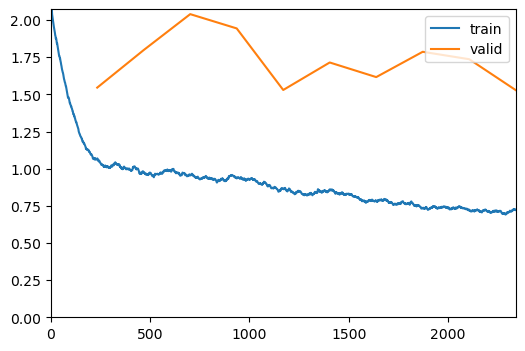

loss: 1.5288479328155518, accuracy:  49.93%


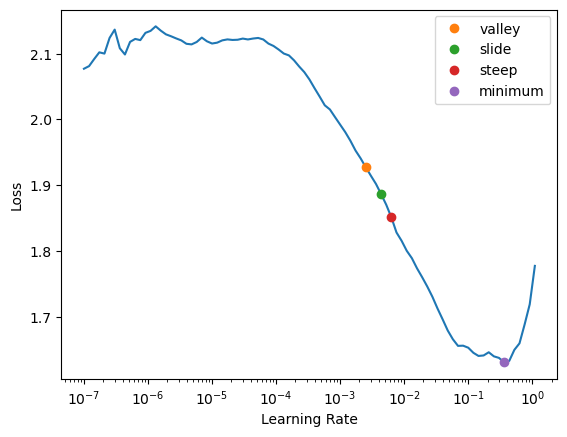

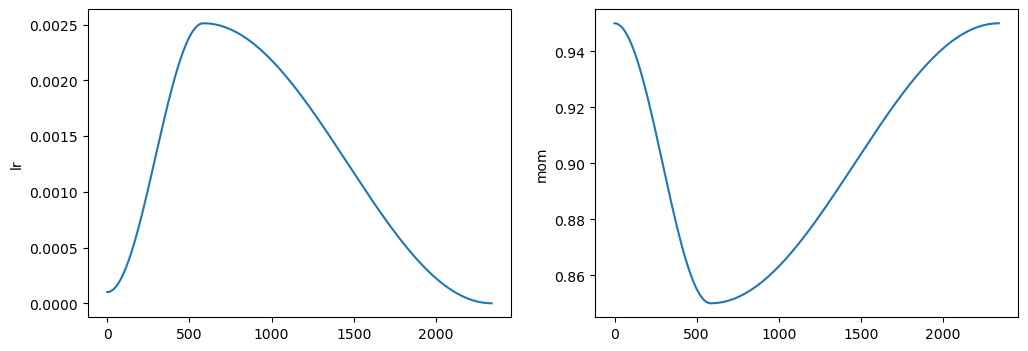

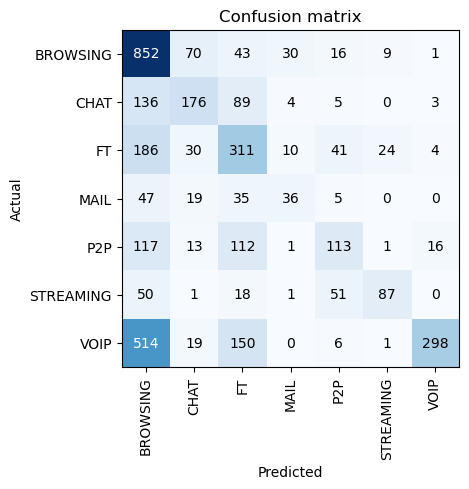

In [15]:
results_dnn = run_deep_nn_experiment(
    df, 
    dataset_1['File'],                 # stuff for logging
    'Traffic Type',                # the column we are trying to predict
    (100 for _ in range(10))           # we use 10 layers with 100 neurons each
)

Shape of Input Data: (18758, 24)
Layer sizes: [23, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 7], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.380920,1.333313,0.547054,0.369615,0.780991,0.427542,0.351224,0.377689,0.369615,00:02
1,1.033612,1.363304,0.554785,0.426417,0.804663,0.443169,0.416447,0.435075,0.426417,00:02
2,0.953696,1.180197,0.580645,0.460388,0.839189,0.475613,0.460002,0.474566,0.460388,00:02
3,0.938856,1.115505,0.625167,0.489079,0.856843,0.527201,0.500914,0.534781,0.489079,00:02
4,0.909031,1.115595,0.614503,0.467137,0.849256,0.512969,0.474296,0.502929,0.467137,00:02
5,0.870686,1.070485,0.639563,0.518810,0.868652,0.547018,0.526662,0.551619,0.518810,00:02
6,0.851458,1.062501,0.634764,0.515315,0.871182,0.542405,0.516814,0.547964,0.515315,00:02
7,0.859741,1.190412,0.546254,0.440729,0.849598,0.439209,0.435380,0.458185,0.440729,00:02
8,0.842297,1.163985,0.572381,0.458840,0.847231,0.466473,0.453979,0.470248,0.458840,00:02
9,0.816669,1.057501,0.631832,0.522600,0.874538,0.540508,0.515838,0.531739,0.522600,00:02


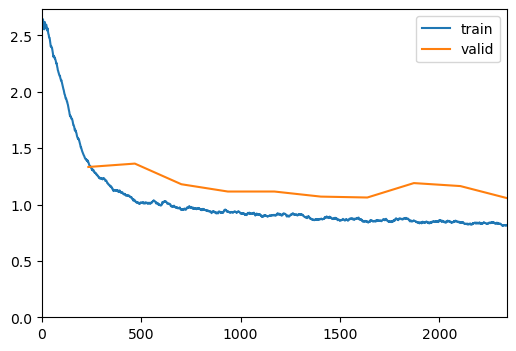

loss: 1.057500958442688, accuracy:  63.18%


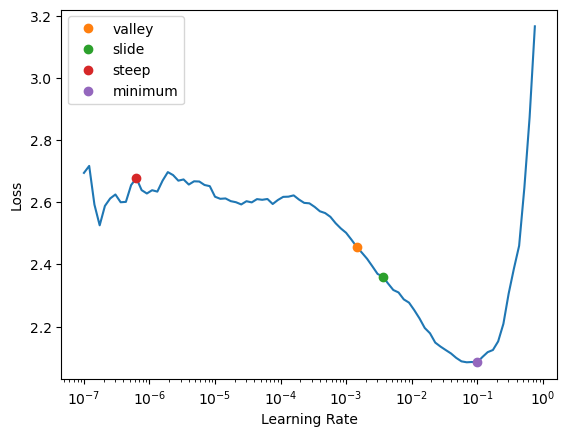

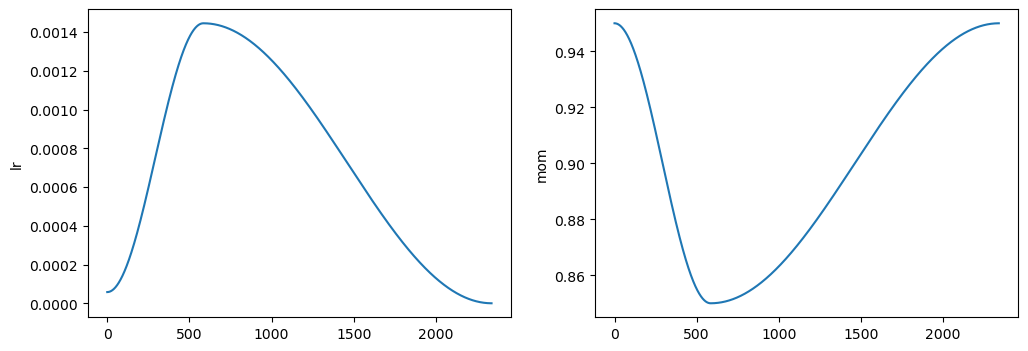

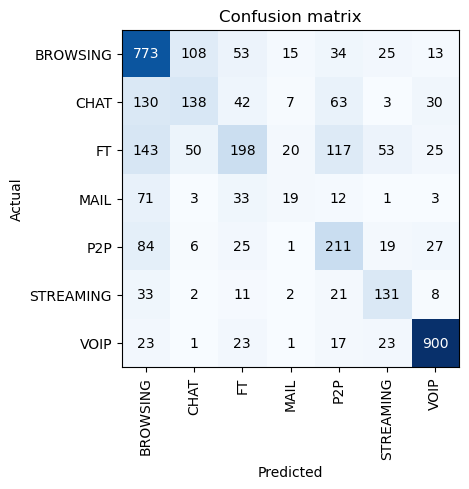

In [28]:
results_res_type_1 = run_residual_deep_nn_experiment(
    df, 
    dataset_1['File'], 
    'Traffic Type', 
    (100 for _ in range(10))
)

In [13]:
# results_sk = run_sk_experiment(
#     df, 
#     dataset_1['File'], 
#     'Traffic Type'
# )

#does not work. Will do it from scratch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=['Traffic Type'])
y = df['Traffic Type']

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Convert DataFrame to NumPy arrays and make them C-contiguous
X_train = np.ascontiguousarray(X_train.values)
X_test = np.ascontiguousarray(X_test.values)
y_train = np.ascontiguousarray(y_train)
y_test = np.ascontiguousarray(y_test)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

pred = knn_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(confusion_matrix(y_test, pred))
print('accuracy:', acc)
print("precision: ", precision_score(y_test, pred, average='weighted'))

[[850  64  27   9  12  12   0]
 [140 226  44  12   7   4   1]
 [ 89  57 362  14  50  10   3]
 [ 13   8  21 102   1   3   1]
 [ 19   6 111   6 260   8   2]
 [ 24   1  20   4   9 126   0]
 [  2   3  10   3   4   2 990]]
accuracy: 0.7771855010660981
precision:  0.776598196459428


In [35]:
results_sk = run_sk_experiment(
    df, 
    dataset_1['File'], 
    'Traffic Type'
)

Shape of Input Data: (18758, 24)
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1021
           1       0.61      0.64      0.62       413
           2       0.74      0.59      0.66       606
           3       0.80      0.77      0.78       142
           4       0.70      0.82      0.76       373
           5       0.90      0.75      0.82       208
           6       0.99      0.97      0.98       988

    accuracy                           0.82      3751
   macro avg       0.79      0.77      0.78      3751
weighted avg       0.82      0.82      0.81      3751

	Accuracy: 0.8163156491602239



In [16]:
class BottleneckResidualBlock(nn.ModuleList):
# class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        super().__init__(branches)
        
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        if(in_size != out_size):
            self.identity_path = LinBnDrop(in_size, out_size)
        else:
            self.identity_path = Identity()


    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.identity_path(inputs)
        return fx + inputs



class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(10)], output_features=8, config: dict = None, device: str = 'cpu'):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]

        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        
        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

scalar = StandardScaler()
# X = scalar.fit_transform(X)

param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'] # Number of features to consider when looking for the best split
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


rf_model = RandomForestClassifier(class_weight='balanced')

search = RandomizedSearchCV(rf_model, param_grid, n_iter=5)

search.fit(X_train, y_train)

best = search.best_estimator_
print(best.get_params)

y_hat = best.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print(confusion_matrix(y_test, y_hat))
print('accuracy:', acc)
print("precision: ", precision_score(y_test, y_hat, average='weighted'))

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour,

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='auto', min_samples_leaf=2,
                       min_samples_split=5)>
[[903  34  18   2   6  11   0]
 [ 58 322  26  10  16   2   0]
 [ 34  38 441  20  40  11   1]
 [  2   6   9 126   4   1   1]
 [  6   9   9   2 381   5   0]
 [ 10   1  11   2   9 151   0]
 [  2   2   8   2   2   2 996]]
accuracy: 0.8848614072494669
precision:  0.8851132082391688


Shape of Input Data: (18758, 24)
0
1
2
3
4
5
6
7
8
9


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.023794,1.858766,0.393228,0.293714,0.820327,0.270112,0.279757,0.457073,0.293714,00:03
1,0.902204,1.863910,0.404959,0.307542,0.812188,0.285155,0.295251,0.549614,0.307542,00:03
2,0.886181,1.677002,0.462543,0.417395,0.841534,0.365429,0.392934,0.525188,0.417395,00:03
3,0.843088,1.751676,0.468142,0.455096,0.845646,0.386095,0.404802,0.500302,0.455096,00:03
4,0.810714,1.880079,0.362037,0.343888,0.812522,0.231417,0.321914,0.401964,0.343888,00:03
5,0.753857,2.246628,0.455612,0.437242,0.789947,0.371181,0.380518,0.544213,0.437242,00:03
6,0.708233,1.624060,0.483338,0.447328,0.858154,0.392134,0.412432,0.528991,0.447328,00:03
7,0.707817,2.027981,0.510264,0.479364,0.812402,0.434698,0.440228,0.563563,0.479364,00:03
8,0.667553,2.207222,0.423354,0.419427,0.790026,0.345089,0.359358,0.523088,0.419427,00:03
9,0.661547,1.731097,0.410024,0.432462,0.869055,0.336022,0.375282,0.457194,0.432462,00:04


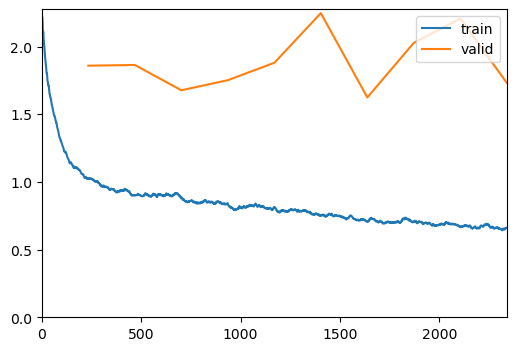

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.7310974597930908, accuracy:  41.00%


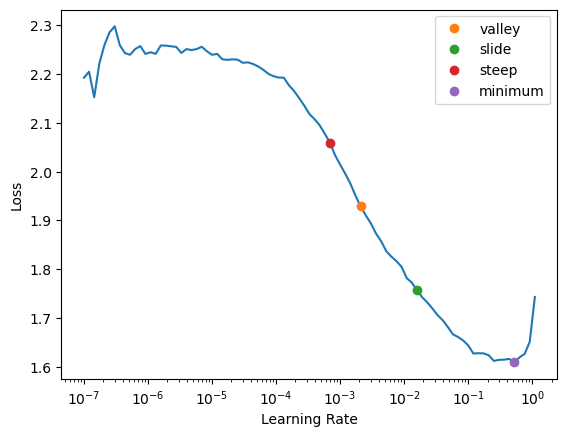

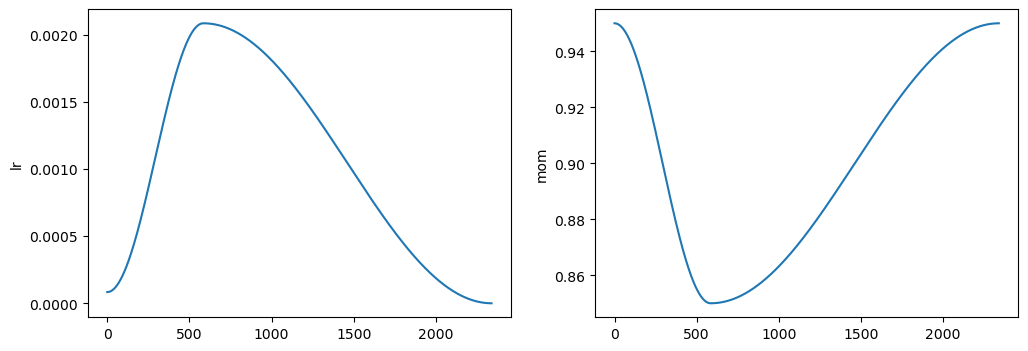

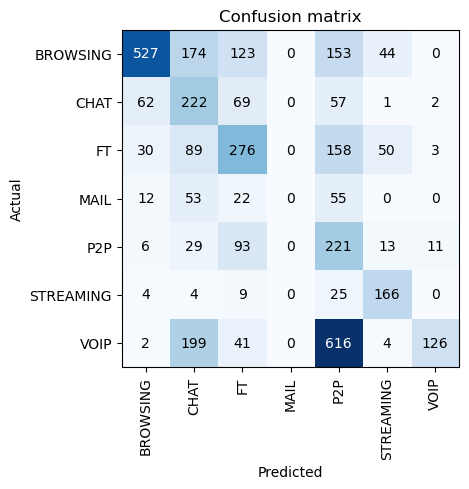

In [17]:
results_res_type_2 = run_torch_nn_experiment(
    df, 
    dataset_1['File'], 
    'Traffic Type', 
    Simple_Resnet_Model,
)

In [25]:
model_1 = results_dnn.model.model.model
model_2 = results_res_type_1.model.model.model
model_3 = results_res_type_2.model.model.model

results_1 = results_dnn.model.model.validate()
results_2 = results_res_type_1.model.model.validate()
results_3 = results_res_type_2.model.model.validate()

print(f"Deep NN 100x10: \t\t\t{sum(p.numel() for p in model_1.parameters() if p.requires_grad)} parameters, {results_1[1]*100} accuracy")
print(f"Deep Res NN 100x10: \t\t\t{sum(p.numel() for p in model_2.parameters() if p.requires_grad)} parameters, {results_2[1]*100} accuracy")
print(f"Simple Res NN 100x10: \t\t{sum(p.numel() for p in model_3.parameters() if p.requires_grad)} parameters, {results_3[1]*100} accuracy")

Deep NN 100x10: 			95154 parameters, 32.213929295539856 accuracy
Deep Res NN 100x10: 			95154 parameters, 65.4850721359253 accuracy
Simple Res NN 100x10: 		88308 parameters, 44.65174078941345 accuracy


In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
assert False, f"Nothing after this point is included in the study. Time: {timestamp}"